# Kapitel 7: Neuronale Netzwerke

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
colors = 'bwr'#['b','y','r']
CMAP = colors#plt.cm.rainbow

In [5]:
from distutils.version import StrictVersion

In [6]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.18.1


In [7]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.1.0')

1.2.1


In [8]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.0')

Using TensorFlow backend.


2.0.6


In [11]:
# Evtl. hat Azure not 0.19, wir brauchen aber .20 fÃ¼r das Plotting, dann das hier installieren und Notebook neu starten
# !conda update pandas -y

In [12]:
import pandas as pd
print(pd.__version__)

assert StrictVersion(pd.__version__) >= StrictVersion('0.20.0')

0.20.1


## Laden und Vorbereiten der Bild-Daten

In [13]:
# !curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip
# from zipfile import ZipFile
# zip = ZipFile(r'speed-limit-signs.zip')
# zip.extractall('.')

In [14]:
!ls -l speed-limit-signs

total 28
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 0
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 1
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 2
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 3
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 4
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 5
-rw-rw-r-- 1 ubuntu ubuntu  380 Jul 21 16:58 README.md


In [15]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

In [16]:
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    return images64, labels

In [17]:
# Load datasets.
ROOT_PATH = "./"
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
images, labels = load_data(original_dir, type=".ppm")

In [18]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)

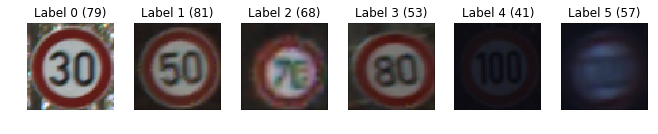

In [19]:
display_images_and_labels(images, labels)
# plt.savefig('ML_0708_signs.png', bbox_inches='tight')

## Modell-Architektur

In [20]:
y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [21]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [22]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       147584    
__________

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Zuerst testen wir unser Modell, ob wir es Ã¼berhaupt trainiert bekommen, indem wir auf einer kleinen Menge von Daten overfitten

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [25]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [34]:
!rm -r tf_log

# https://keras.io/callbacks/#tensorboard
tb_callback = keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=/mnt/c/Users/olive/Development/ml/tf_log
# open http://localhost:6006

In [ ]:
%time model.fit(X_train, y_train, epochs=100, validation_split=0.3, callbacks=[tb_callback])

## Das sieht gut aus, nun versuchen wir es mit dem kompletten Datensatz ohne Overfitting und mit Dropout

In [112]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

drop_out = 0.6

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [113]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 128)       73856     
__________

In [114]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [98]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1)

In [99]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('./model-checkpoints/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5');

In [100]:
!rm -r tf_log

In [101]:
# Depends on harware GPU architecture, set as high as possible (this works well on K80)
BATCH_SIZE = 500
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback, early_stopping_callback])
%time model.fit(X_train, y_train, epochs=250, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

Train on 242 samples, validate on 61 samples
Epoch 1/500
242/242 [==============================] - 1s - loss: 1.8217 - acc: 0.1488 - val_loss: 1.7431 - val_acc: 0.0984
Epoch 2/500
242/242 [==============================] - 0s - loss: 1.7643 - acc: 0.2273 - val_loss: 1.7637 - val_acc: 0.2787
Epoch 3/500
242/242 [==============================] - 0s - loss: 1.7274 - acc: 0.2025 - val_loss: 1.7752 - val_acc: 0.3607
Epoch 4/500
242/242 [==============================] - 0s - loss: 1.7258 - acc: 0.2273 - val_loss: 1.7663 - val_acc: 0.3607
Epoch 5/500
242/242 [==============================] - 0s - loss: 1.7133 - acc: 0.2355 - val_loss: 1.7406 - val_acc: 0.2787
Epoch 6/500
242/242 [==============================] - 0s - loss: 1.7162 - acc: 0.2231 - val_loss: 1.7609 - val_acc: 0.1148
Epoch 7/500
242/242 [==============================] - 0s - loss: 1.6820 - acc: 0.2190 - val_loss: 1.7739 - val_acc: 0.1475
Epoch 8/500
242/242 [==============================] - 0s - loss: 1.6770 - acc: 0.2355 

242/242 [==============================] - 0s - loss: 1.3828 - acc: 0.4339 - val_loss: 1.5647 - val_acc: 0.3443
Epoch 67/500
242/242 [==============================] - 0s - loss: 1.3837 - acc: 0.4339 - val_loss: 1.5401 - val_acc: 0.3443
Epoch 68/500
242/242 [==============================] - 0s - loss: 1.3928 - acc: 0.4380 - val_loss: 1.5571 - val_acc: 0.3443
Epoch 69/500
242/242 [==============================] - 0s - loss: 1.3507 - acc: 0.4132 - val_loss: 1.6644 - val_acc: 0.2623
Epoch 70/500
242/242 [==============================] - 0s - loss: 1.3481 - acc: 0.4298 - val_loss: 1.5388 - val_acc: 0.3770
Epoch 71/500
242/242 [==============================] - 0s - loss: 1.3219 - acc: 0.4421 - val_loss: 1.5173 - val_acc: 0.3934
Epoch 72/500
242/242 [==============================] - 0s - loss: 1.3212 - acc: 0.4504 - val_loss: 1.5569 - val_acc: 0.3770
Epoch 73/500
242/242 [==============================] - 0s - loss: 1.3199 - acc: 0.4628 - val_loss: 1.5790 - val_acc: 0.3607
Epoch 74/500


242/242 [==============================] - 0s - loss: 0.5022 - acc: 0.8099 - val_loss: 1.4536 - val_acc: 0.6393
Epoch 132/500
242/242 [==============================] - 0s - loss: 0.5250 - acc: 0.8017 - val_loss: 1.3610 - val_acc: 0.6885
Epoch 133/500
242/242 [==============================] - 0s - loss: 0.5090 - acc: 0.8347 - val_loss: 1.1457 - val_acc: 0.7213
Epoch 134/500
242/242 [==============================] - 0s - loss: 0.6039 - acc: 0.7934 - val_loss: 1.0280 - val_acc: 0.7705
Epoch 135/500
242/242 [==============================] - 0s - loss: 0.4257 - acc: 0.8471 - val_loss: 1.2336 - val_acc: 0.6885
Epoch 136/500
242/242 [==============================] - 0s - loss: 0.5316 - acc: 0.8223 - val_loss: 1.4374 - val_acc: 0.7213
Epoch 137/500
242/242 [==============================] - 0s - loss: 0.3600 - acc: 0.9050 - val_loss: 1.4829 - val_acc: 0.7377
Epoch 138/500
242/242 [==============================] - 0s - loss: 0.4084 - acc: 0.8678 - val_loss: 1.1005 - val_acc: 0.7541
Epoch 

242/242 [==============================] - 0s - loss: 0.0709 - acc: 0.9711 - val_loss: 0.6053 - val_acc: 0.8689
Epoch 197/500
242/242 [==============================] - 0s - loss: 0.0445 - acc: 0.9793 - val_loss: 1.0248 - val_acc: 0.8525
Epoch 198/500
242/242 [==============================] - 0s - loss: 0.0537 - acc: 0.9793 - val_loss: 1.0502 - val_acc: 0.8525
Epoch 199/500
242/242 [==============================] - 0s - loss: 0.0754 - acc: 0.9628 - val_loss: 0.7277 - val_acc: 0.8852
Epoch 200/500
242/242 [==============================] - 0s - loss: 0.0881 - acc: 0.9711 - val_loss: 0.5295 - val_acc: 0.8852
Epoch 201/500
242/242 [==============================] - 0s - loss: 0.0440 - acc: 0.9876 - val_loss: 0.4781 - val_acc: 0.8852
Epoch 202/500
242/242 [==============================] - 0s - loss: 0.0698 - acc: 0.9793 - val_loss: 0.4893 - val_acc: 0.8852
Epoch 203/500
242/242 [==============================] - 0s - loss: 0.0642 - acc: 0.9711 - val_loss: 0.5076 - val_acc: 0.8852
Epoch 

242/242 [==============================] - 0s - loss: 0.0269 - acc: 0.9835 - val_loss: 0.6038 - val_acc: 0.8852
Epoch 262/500
242/242 [==============================] - 0s - loss: 0.0389 - acc: 0.9876 - val_loss: 0.5863 - val_acc: 0.9016
Epoch 263/500
242/242 [==============================] - 0s - loss: 0.0295 - acc: 0.9917 - val_loss: 0.5942 - val_acc: 0.9016
Epoch 264/500
242/242 [==============================] - 0s - loss: 0.0336 - acc: 0.9876 - val_loss: 0.6120 - val_acc: 0.9180
Epoch 265/500
242/242 [==============================] - 0s - loss: 0.0225 - acc: 0.9876 - val_loss: 0.6167 - val_acc: 0.9016
Epoch 266/500
242/242 [==============================] - 0s - loss: 0.0437 - acc: 0.9917 - val_loss: 0.6342 - val_acc: 0.9180
Epoch 267/500
242/242 [==============================] - 0s - loss: 0.0337 - acc: 0.9917 - val_loss: 0.6493 - val_acc: 0.9180
Epoch 268/500
242/242 [==============================] - 0s - loss: 0.0072 - acc: 1.0000 - val_loss: 0.6548 - val_acc: 0.9180
Epoch 

242/242 [==============================] - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.4977 - val_acc: 0.9344
Epoch 327/500
242/242 [==============================] - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.4989 - val_acc: 0.9344
Epoch 328/500
242/242 [==============================] - 0s - loss: 0.0171 - acc: 0.9959 - val_loss: 0.5022 - val_acc: 0.9344
Epoch 329/500
242/242 [==============================] - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.4906 - val_acc: 0.9344
Epoch 330/500
242/242 [==============================] - 0s - loss: 0.0138 - acc: 0.9917 - val_loss: 0.4540 - val_acc: 0.9344
Epoch 331/500
242/242 [==============================] - 0s - loss: 0.0250 - acc: 0.9835 - val_loss: 0.4200 - val_acc: 0.9344
Epoch 332/500
242/242 [==============================] - 0s - loss: 0.0061 - acc: 0.9959 - val_loss: 0.4090 - val_acc: 0.9344
Epoch 333/500
242/242 [==============================] - 0s - loss: 0.0046 - acc: 1.0000 - val_loss: 0.4210 - val_acc: 0.9344
Epoch 

242/242 [==============================] - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.4199 - val_acc: 0.9344
Epoch 392/500
242/242 [==============================] - 0s - loss: 0.0198 - acc: 0.9959 - val_loss: 0.4240 - val_acc: 0.9344
Epoch 393/500
242/242 [==============================] - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4654 - val_acc: 0.9344
Epoch 394/500
242/242 [==============================] - 0s - loss: 0.0094 - acc: 0.9917 - val_loss: 0.5900 - val_acc: 0.9180
Epoch 395/500
242/242 [==============================] - 0s - loss: 0.0075 - acc: 0.9959 - val_loss: 0.7429 - val_acc: 0.9016
Epoch 396/500
242/242 [==============================] - 0s - loss: 0.0095 - acc: 0.9959 - val_loss: 0.7776 - val_acc: 0.9016
Epoch 397/500
242/242 [==============================] - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.7866 - val_acc: 0.9180
Epoch 398/500
242/242 [==============================] - 0s - loss: 0.0109 - acc: 0.9959 - val_loss: 0.7638 - val_acc: 0.9180
Epoch 

242/242 [==============================] - 0s - loss: 0.0042 - acc: 0.9959 - val_loss: 0.4831 - val_acc: 0.9344
Epoch 457/500
242/242 [==============================] - 0s - loss: 0.0109 - acc: 0.9959 - val_loss: 0.4811 - val_acc: 0.9344
Epoch 458/500
242/242 [==============================] - 0s - loss: 0.0062 - acc: 0.9959 - val_loss: 0.4808 - val_acc: 0.9344
Epoch 459/500
242/242 [==============================] - 0s - loss: 0.0066 - acc: 1.0000 - val_loss: 0.4911 - val_acc: 0.9344
Epoch 460/500
242/242 [==============================] - 0s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.5066 - val_acc: 0.9344
Epoch 461/500
242/242 [==============================] - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.5256 - val_acc: 0.9344
Epoch 462/500
242/242 [==============================] - 0s - loss: 0.0181 - acc: 0.9917 - val_loss: 0.5445 - val_acc: 0.9344
Epoch 463/500
242/242 [==============================] - 0s - loss: 0.0105 - acc: 0.9959 - val_loss: 0.5514 - val_acc: 0.9344
Epoch 

# Bewertung

In [102]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

303/303 [==============================] - 0s


(0.095115035772323608, 0.98349833488464355)

In [103]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

76/76 [==============================] - 0s


(0.11827723681926727, 0.94736844301223755)

# Sichern des Modells

In [104]:
# !rm -r models
# !mkdir models

In [105]:
model.save('models/conv-vgg.hdf5')

In [106]:
!ls -lh models

total 55M
-rw-rw-r-- 1 ubuntu ubuntu 55M Aug  8 17:33 conv-vgg.hdf5


In [108]:
!curl --upload-file ./models/conv-vgg.hdf5 https://transfer.sh/conv-vgg.hdf5

https://transfer.sh/3NqDF/conv-vgg.hdf5

# Ausprobieren auf ein paar Test-Daten

In [109]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([1, 1, 5, 1, 4, 0, 1, 3, 0, 1])

In [110]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

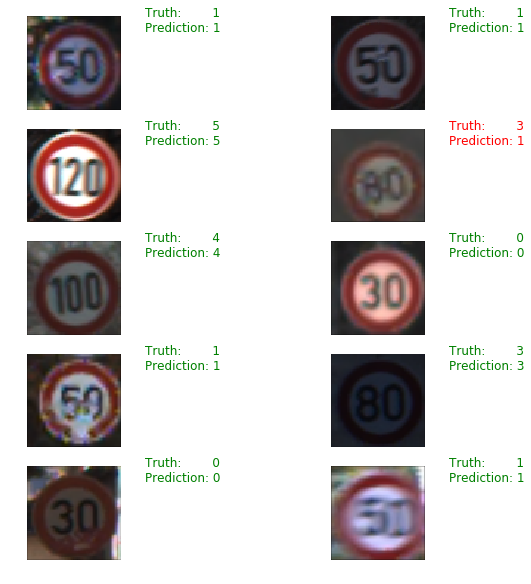

In [111]:
display_prediction(sample_images, ground_truth, predicted_categories)